Begin by importing necessary functions and packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import torch
# from torch import nn
# from torch import optim
# from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall

2024-08-12 19:17:57.272269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Upload CSV file of handwrriten data files.

In [2]:
alphabet_data = pd.read_csv('A_Z Handwritten Data.csv')

Exploring the data frame, we see that the maximum pixel value is 255. A common preprocessing step for images is to normalize the pixels between 0 and 1 to ensure scale variance and allow for faster convergence. Therewfore, we will divide every entry in the dataframe by the max pixel value.

In [3]:
max_pixel = 255
normalized_df = alphabet_data.drop(columns=['0']).applymap(lambda x: x/max_pixel)
preprocessed_alphabet_data = pd.concat([pd.DataFrame(alphabet_data['0']),normalized_df],axis=1)

For each entry (row) in the data frame: the first column corresponds with the letter of the alphabet where 0 corresponds to 'A' through 26 corresponds to 'Z,' the next $28^2$ correspond to the 28 x 28 pixelated image of a letter. Let's start by creating a function to visualize a given entry.

In [4]:
def plot_image(row, plot = False):
    if row >= preprocessed_alphabet_data.shape[0]:
        print(f'There is no row indexed by {row}.')
    else:
        letter = preprocessed_alphabet_data.iloc[row][1:].values.reshape((28,28,1)).astype('float32')
        if plot == True:
            plt.imshow(letter,cmap='binary')
        else:
            return letter

In [5]:
preprocessed_alphabet_data.iloc[1][0].reshape((1,1,)).shape

(1, 1)

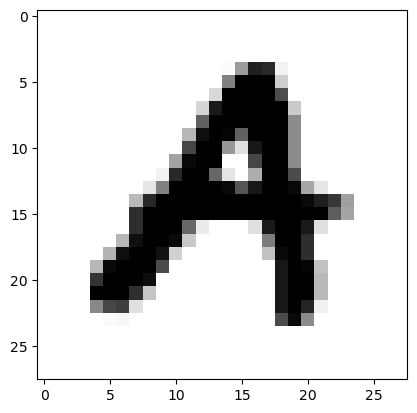

In [6]:
plot_image(34,plot=True)

In [7]:
letters = []
images = []
for i in range(preprocessed_alphabet_data.shape[0]):
    # letters.append(chr(65+alphabet_data.iloc[i][0])) # Can't use strings for processing into tensors
    letters.append(preprocessed_alphabet_data.iloc[i][0].astype('int'))
    images.append(plot_image(i))
letters = np.array(letters)
images = np.array(images)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, letters, test_size=0.33, random_state=42)
print(f'X has shape {X_train.shape} and y has shape {y_train.shape}.')

X has shape (249541, 28, 28, 1) and y has shape (249541,).


In [9]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=26)

In [13]:
# Variables
INPUT_SHAPE = (28,28,1)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = 26

# Model architecture implementation
model = Sequential()
model.add(Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation='relu'))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [16]:
BATCH_SIZE = 32
EPOCHS = 30

METRICS = metrics=['accuracy',
               	Precision(name='precision'),
               	Recall(name='recall')]

model.compile(optimizer='adam',
          	loss='categorical_crossentropy',
          	metrics = METRICS)

# Train the model
training_history = model.fit(X_train, y_train,
                	epochs=EPOCHS, batch_size=BATCH_SIZE,
                	validation_data=(X_test, y_test))

Epoch 1/30
7799/7799 [==============================] - 107s 14ms/step - loss: 0.1297 - accuracy: 0.9630 - precision: 0.9744 - recall: 0.9557 - val_loss: 0.0630 - val_accuracy: 0.9826 - val_precision: 0.9856 - val_recall: 0.9804
Epoch 2/30
7799/7799 [==============================] - 105s 13ms/step - loss: 0.0493 - accuracy: 0.9858 - precision: 0.9876 - recall: 0.9844 - val_loss: 0.0514 - val_accuracy: 0.9861 - val_precision: 0.9875 - val_recall: 0.9851
Epoch 3/30
7799/7799 [==============================] - 115s 15ms/step - loss: 0.0321 - accuracy: 0.9907 - precision: 0.9916 - recall: 0.9900 - val_loss: 0.0467 - val_accuracy: 0.9871 - val_precision: 0.9884 - val_recall: 0.9862
Epoch 4/30
7799/7799 [==============================] - 118s 15ms/step - loss: 0.0225 - accuracy: 0.9932 - precision: 0.9937 - recall: 0.9927 - val_loss: 0.0350 - val_accuracy: 0.9914 - val_precision: 0.9919 - val_recall: 0.9910
Epoch 5/30
7799/7799 [==============================] - 111s 14ms/step - loss: 0.016

# This is where you finished off!

In [17]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

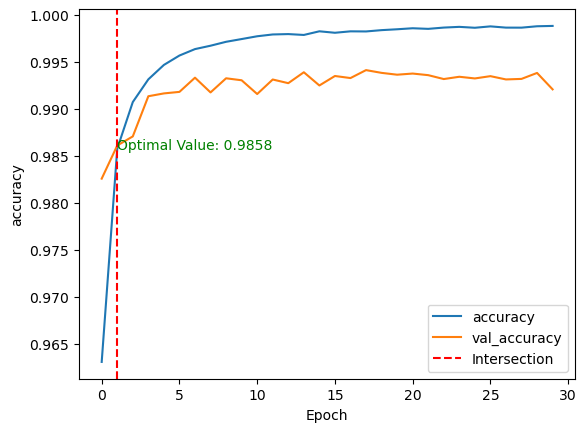

In [18]:
show_performance_curve(training_history, 'accuracy', 'accuracy')


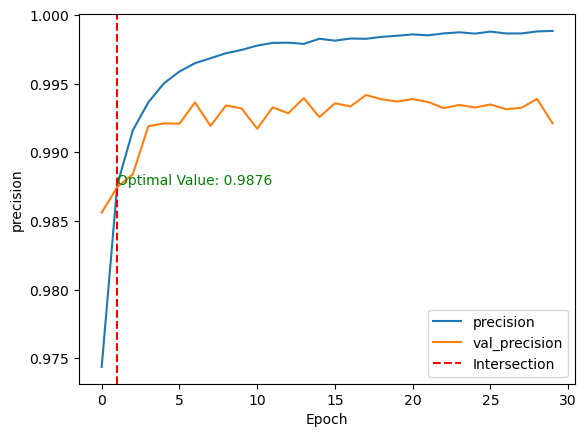

In [19]:
show_performance_curve(training_history, 'precision', 'precision')

3841/3841 [==============================] - 14s 4ms/step


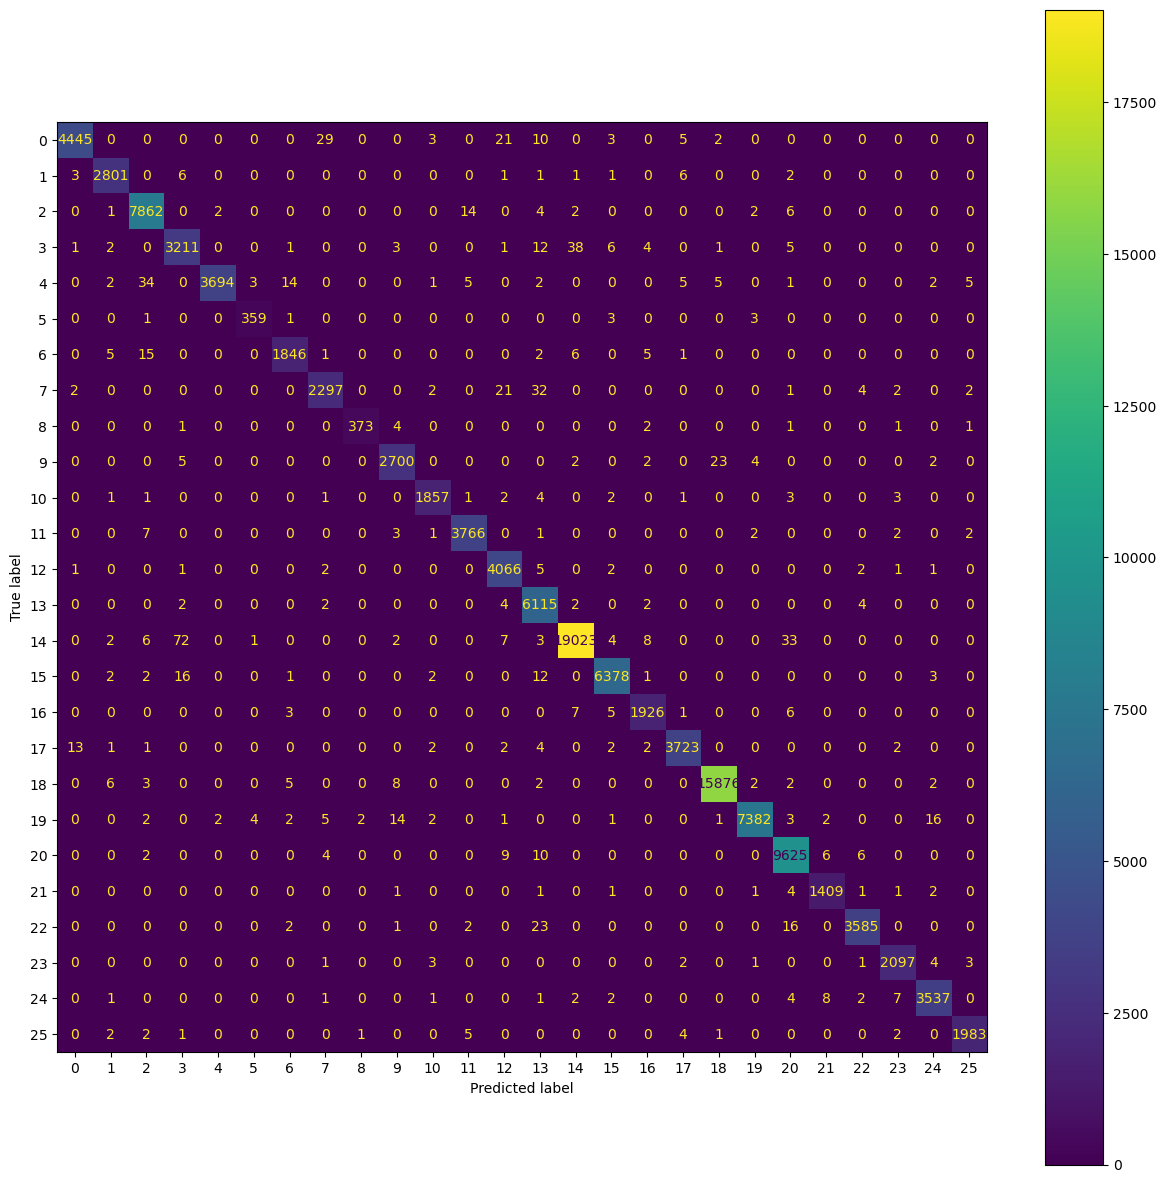

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_predictions = model.predict(X_test)

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(test_true_labels, test_predicted_labels)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(15,15))

cmd.plot(ax=ax, include_values=True, cmap='viridis', xticks_rotation='horizontal')
plt.show()